/tmp/ipython-input-1171910500.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df=pd.read_csv("/content/gold_rates_new.csv", parse_dates=["Dates"])


Gold rates: date vs price
                 Prices
Dates                  
2021-12-31  3974.926850
2022-01-31  3983.857038
2022-02-28  4101.708994
2022-03-31  4374.952113
2022-04-30  4341.848525


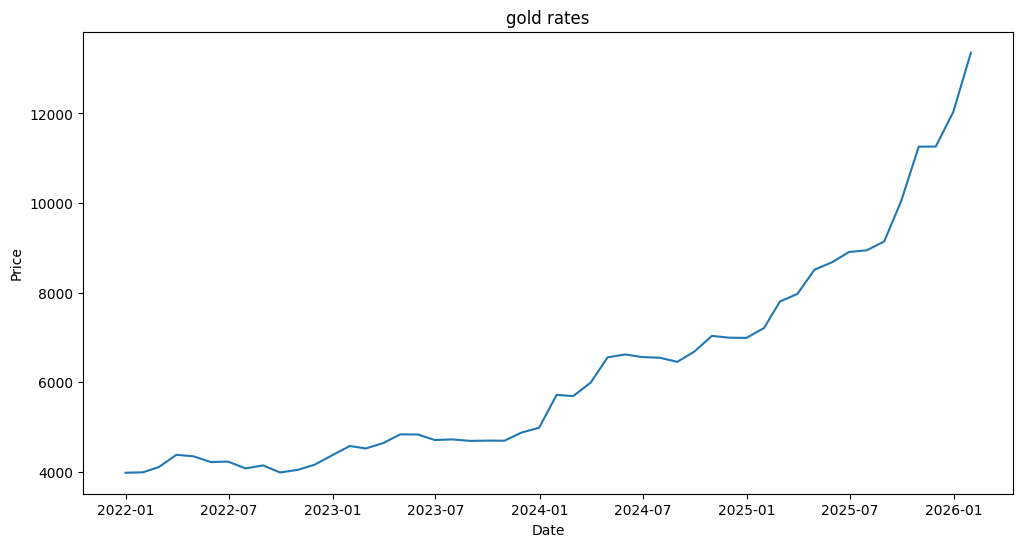

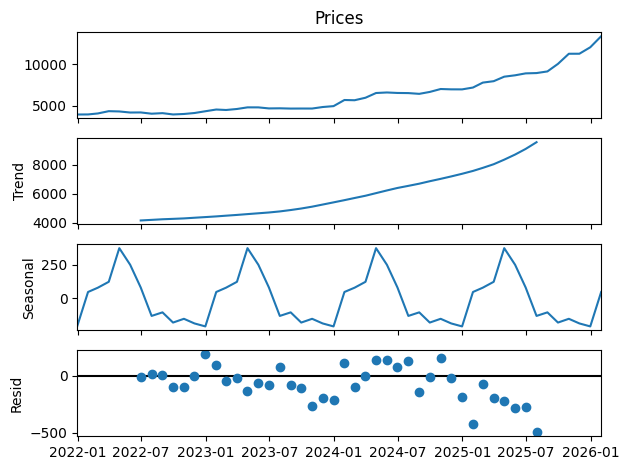

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Enter the date (YYYY-MM-DD): 2026-03-15
 The average price is 14874.271056884598 and price with import duty(6%) and GST(3%) is  16239.729139906605
 The maximum price (95% CI) with taxes is : 16701.12


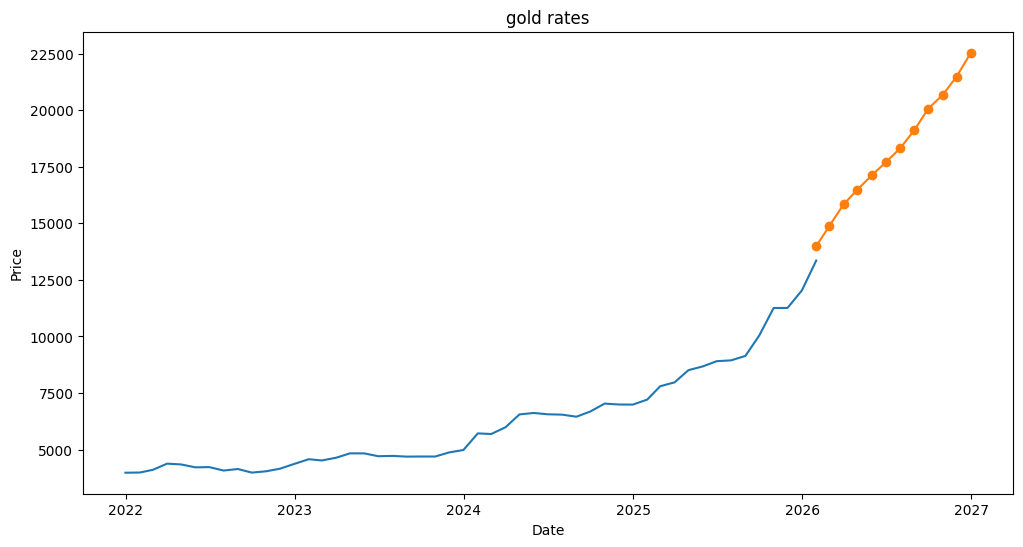

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df=pd.read_csv("/content/gold_rates_new.csv", parse_dates=["Dates"])
df["Prices"]=df["Prices"].astype(float)
df.set_index("Dates", inplace=True)
df.sort_index(inplace=True) # Sort the DataFrame by date for time series analysis
print("Gold rates: date vs price")
print(df.head())

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Prices'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('gold rates')
plt.show()

decomp=seasonal_decompose(df["Prices"], period=12)
decomp.plot()
plt.show()

model=ExponentialSmoothing(df["Prices"], trend="add", seasonal="add", seasonal_periods=12).fit()

forecast=model.forecast(12)
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Prices'],label='Historical')
plt.plot(pd.date_range(df.index[-1], periods=12, freq="ME"), forecast, label="Forecast", marker="o") # Changed freq="M" to freq="ME"
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('gold rates')

import_duty=1.06  # 6% import duty
GST=1.03          # 3% GST
std_dev=np.std(model.resid)
z_score=1.96
def estimate_price(date):

  if date in df.index:
    av_amount= df.loc[date,"Prices"]
    with_tax_amount= av_amount * import_duty *GST
    print(f" The average price is {av_amount} and price with import duty(6%) and GST(3%) is  {with_tax_amount}")

  elif date > df.index[-1]:
    future=(date.year-df.index[-1].year)*12+(date.month-df.index[-1].month)
    av_amount= float((model.forecast(future).iloc[-1])) # Changed [-1] to .iloc[-1]
    max_price_base=av_amount+(std_dev*z_score)
    max_with_tax=max_price_base*import_duty*GST
    with_tax_amount= av_amount * import_duty *GST
    print(f" The average price is {av_amount} and price with import duty(6%) and GST(3%) is  {with_tax_amount}")
    print(f" The maximum price (95% CI) with taxes is : {max_with_tax:.2f}")
  else:
    av_amount= float((df["Prices"].reindex(df.index.union([date])).interpolate().loc[date])) # Changed [-1] to .iloc[-1]
    with_tax_amount= av_amount * import_duty *GST
    print(f" The average price is {av_amount} and price with import duty(6%) and GST(3%) is  {with_tax_amount}")

date_str=str(input("Enter the date (YYYY-MM-DD): "))
date=pd.to_datetime(date_str)
estimate_price(date)